# Packages

In [1]:
import GRN
import GRNCreationUtils
from utils import *
from genesGroup import subgraph3N
import pandas as pd
import networkx as nx
import matplotlib as plt

# Functions

In [2]:
import networkx as nx
import itertools
from collections import Counter
from networkx.algorithms.isomorphism import DiGraphMatcher

def generate_motif_templates():
    """Returns a dictionary of canonical 3-node motif templates."""
    templates = {}

    def add_motif(name, edges):
        G = nx.DiGraph()
        G.add_edges_from(edges)
        templates[name] = G

    # Basic motif types (based on Alon 2002 classification)
    add_motif("Fan-In", [(1, 0), (2, 0)])
    add_motif("Fan-Out", [(0, 1), (0, 2)])
    add_motif("Cascade", [(0, 1), (1, 2)])
    add_motif("FFL", [(0, 1), (1, 2), (0, 2)])
    add_motif("FBL", [(0, 1), (1, 2), (2, 0)])
    add_motif("Bi-Mutual", [(0, 1), (1, 0), (1, 2), (2, 1)])
    add_motif("Clique", [(0, 1), (1, 0), (0, 2), (2, 0), (1, 2), (2, 1)])
    # Add more motifs if needed

    return templates


def classify_subgraph(subG, motif_templates):
    """Matches a 3-node subgraph to a motif type using isomorphism."""
    for name, motifG in motif_templates.items():
        matcher = DiGraphMatcher(subG, motifG)
        if matcher.is_isomorphic():
            return name
    return "Other"


def count_motifs(G):
    """
    Enumerates and classifies all 3-node subgraphs in a directed graph.
    
    Returns:
        motif_counts (Counter): motif type -> count
    """
    motif_templates = generate_motif_templates()
    motif_counts = Counter()
    
    for nodes in itertools.combinations(G.nodes, 3):
        subG = G.subgraph(nodes).copy()
        if nx.is_weakly_connected(subG):  # Optional: only count connected
            motif_type = classify_subgraph(subG, motif_templates)
            motif_counts[motif_type] += 1

    return motif_counts


def randomize_graph(G, n_swaps=1000, seed=None):
    """
    Returns a randomized version of the graph preserving in/out-degree distribution.
    Uses the Maslov-Sneppen edge-rewiring algorithm.
    """
    G_rand = G.copy()
    nx.double_edge_swap(G_rand, n_swaps=n_swaps, max_tries=n_swaps * 10, seed=seed)
    return G_rand

# GRNgene

In [13]:
import networkx as nx
import numpy as np
import random as rd

# --- Direction assignment function (star-based) ---
def adjacenteDiMatriceStaredFromGraph(G: nx.Graph,
                                      autoRG: float,
                                      duoRG: float) -> nx.DiGraph:
    """
    Converts an undirected graph into a directed graph
    using a 'star' strategy: the highest-degree node is treated as a hub,
    and edges are oriented outward (with optional bidirectionality and self-loops).
    """
    DiG = nx.DiGraph()
    DiG.add_nodes_from(G)

    # Find the hub node (highest degree)
    degree_dict = dict(G.degree())
    motherNode = max(degree_dict, key=degree_dict.get)
    print(f"Hub node selected for directionality: {motherNode}")

    cache = set()
    distance = nx.single_source_shortest_path_length(G, motherNode)

    for nodeA in distance:
        for nodeB in G[nodeA]:
            edge = (nodeA, nodeB)
            if edge not in cache:
                cache.add(edge)
                cache.add(edge[::-1])
                rdNumber = rd.random()
                if rdNumber < duoRG:
                    DiG.add_edges_from([(nodeA, nodeB), (nodeB, nodeA)])
                else:
                    if distance[nodeA] <= distance[nodeB]:
                        DiG.add_edge(nodeA, nodeB)
                    else:
                        DiG.add_edge(nodeB, nodeA)
        if rd.random() < autoRG:
            DiG.add_edge(nodeA, nodeA)

    return DiG

# --- Connect components probabilistically by degree ---
def connect_components_by_degree(G, hub_bias=1.0):
    """
    Connects disconnected components by adding edges between them.
    Nodes are chosen with probability proportional to (degree ** hub_bias).
    """
    added_edges = 0
    while not nx.is_connected(G):
        components = list(nx.connected_components(G))
        compA, compB = components[0], components[1]

        degrees_A = np.array([G.degree(n) for n in compA])
        degrees_B = np.array([G.degree(n) for n in compB])

        # Amplify hub preference
        degrees_A = (degrees_A + 1e-3) ** hub_bias
        degrees_B = (degrees_B + 1e-3) ** hub_bias

        prob_A = degrees_A / degrees_A.sum()
        prob_B = degrees_B / degrees_B.sum()

        nodeA = np.random.choice(list(compA), p=prob_A)
        nodeB = np.random.choice(list(compB), p=prob_B)

        G.add_edge(nodeA, nodeB)
        added_edges += 1
        print(f"Connected node {nodeA} (deg={G.degree(nodeA)}) with {nodeB} (deg={G.degree(nodeB)})")

    print(f"Graph is now connected (added {added_edges} edges).")
    return G

# --- LFR generation with retry loop ---
def safe_LFR_benchmark(max_retries=10, **kwargs):
    attempt = 0
    while True:
        try:
            attempt += 1
            G = nx.generators.community.LFR_benchmark_graph(**kwargs)
            print(f"Successfully generated LFR graph on attempt {attempt}.")
            return G, attempt
        except nx.ExceededMaxIterations:
            print(f"Generation failed on attempt {attempt}, retrying...")
            if attempt >= max_retries:
                raise RuntimeError(f"Exceeded max retries ({max_retries}). LFR generation failed.")

# --- MAIN SCRIPT ---

# Define your parameters here
LFR_params = dict(
    n=1525,
    tau1=2.5,
    tau2=2.162,
    mu=0.1,
    average_degree=2.5,
    min_community=10,
    seed=789  # random seed each time for variability
)

# Generate LFR graph with retry loop
G_lfr, attempts = safe_LFR_benchmark(**LFR_params)

# Connect components if needed (with strong hub preference)
if not nx.is_connected(G_lfr):
    G_lfr = connect_components_by_degree(G_lfr, hub_bias=3.0)  # <<<< amplify hub bias here
else:
    print("LFR graph was already connected.")

# Apply direction assignment
G_lfr_directed = adjacenteDiMatriceStaredFromGraph(
    G_lfr,
    autoRG=0.0,   # self-loop probability
    duoRG=0.00    # bidirectional edge probability
)

print(f"Finished! LFR graph generated in {attempts} attempt(s) and directed graph created.")


Successfully generated LFR graph on attempt 1.
Connected node 877 (deg=17) with 723 (deg=3)
Connected node 1489 (deg=37) with 5 (deg=3)
Connected node 1308 (deg=31) with 8 (deg=3)
Connected node 1489 (deg=38) with 519 (deg=3)
Connected node 795 (deg=32) with 18 (deg=5)
Connected node 761 (deg=26) with 218 (deg=4)
Connected node 761 (deg=27) with 668 (deg=4)
Connected node 1519 (deg=32) with 26 (deg=4)
Connected node 713 (deg=18) with 455 (deg=4)
Connected node 1183 (deg=18) with 1322 (deg=2)
Connected node 263 (deg=14) with 34 (deg=3)
Connected node 1183 (deg=19) with 445 (deg=2)
Connected node 1192 (deg=37) with 826 (deg=3)
Connected node 1192 (deg=38) with 1079 (deg=2)
Connected node 1519 (deg=33) with 371 (deg=2)
Connected node 1489 (deg=39) with 149 (deg=2)
Connected node 1519 (deg=34) with 49 (deg=3)
Connected node 795 (deg=33) with 89 (deg=5)
Connected node 761 (deg=28) with 615 (deg=3)
Connected node 1489 (deg=40) with 1456 (deg=2)
Connected node 761 (deg=29) with 1493 (deg=3)
C

The graph has been loaded as directed graph.
Plotting the graph...
Computing the degree distribution...
Plotting the scale free verification...
Fitting the power law distribution to the degree distribution...


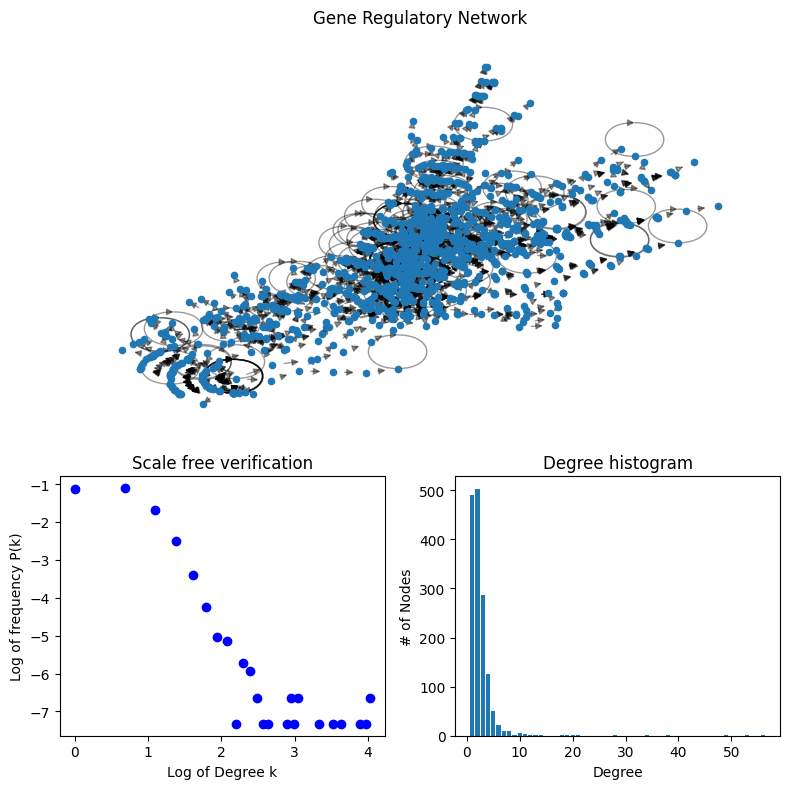

Graph strongly connected: False
Graph weakly connected: True
Modularity of the graph: 0.9307221904634783
Fitted power law parameters: a = 0.38, b = -1.09


In [14]:
lfr_adj_mx = nx.adjacency_matrix(G_lfr_directed)
plot_grn_degree(lfr_adj_mx, plot_network=True)
lfr_properties = graph_properties(lfr_adj_mx)

# E Coli

The graph has been loaded as directed graph.
Plotting the graph...
Computing the degree distribution...
Plotting the scale free verification...
Fitting the power law distribution to the degree distribution...


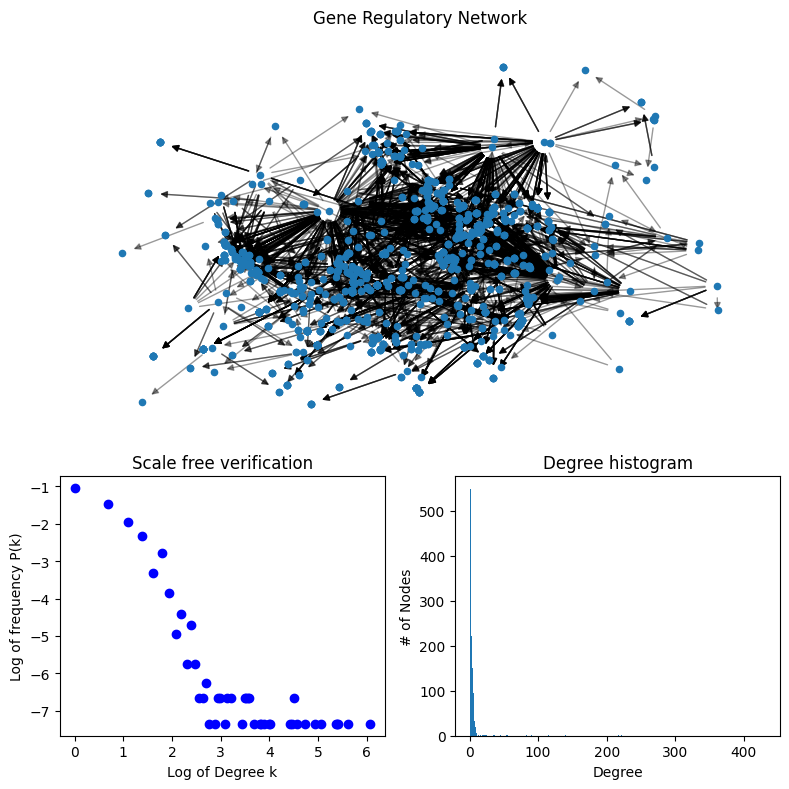

Graph strongly connected: False
Graph weakly connected: False
Modularity of the graph: 0.5577196972821129
Fitted power law parameters: a = 0.38, b = -1.17


In [3]:
'''
Full network
'''

filepath = 'data/gnw/Ecoli-full.tsv'
adj_mx = adj_mx_gnw_goldstandard(filepath)
plot_grn_degree(adj_mx, plot_network=True)
gnw_properties = graph_properties(adj_mx)

In [6]:
filepath = 'data/gnw/Ecoli-full.tsv'
df = pd.read_csv(filepath, sep="\t", header=None, names=["source", "target", "interaction"])
active_edges = df[df["interaction"] == 1]
G = nx.from_pandas_edgelist(active_edges, source="source", target="target",create_using=nx.DiGraph)
gnw_motifs = subgraph3N(G)

# Comparison

KS Statistic: 0.09908389585342334, p-value: 4.652385302808678e-07
Generated GRN Clustering Coefficient: 0.0650505603658642
Known GRN Clustering Coefficient: 0.13291362343159122


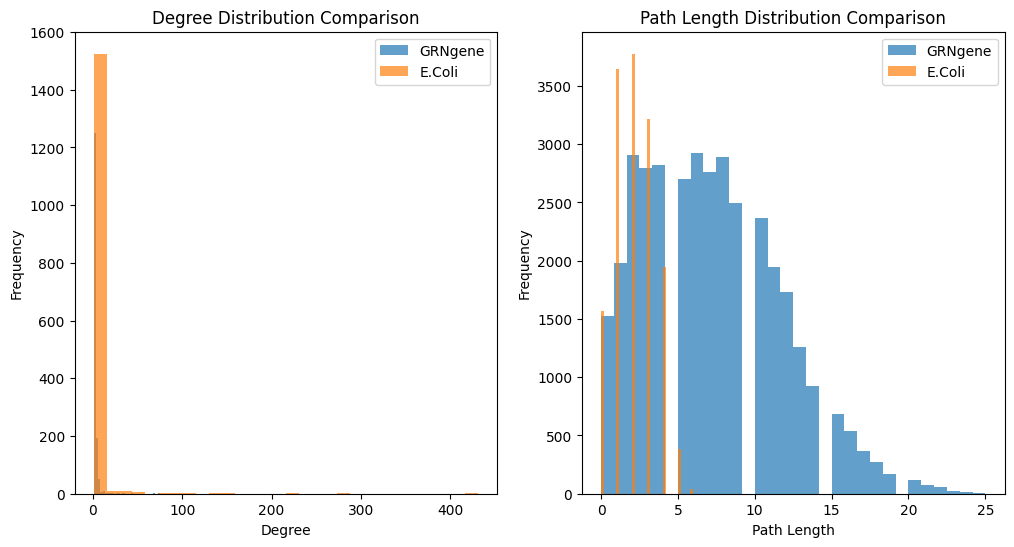

Generated GRN Assortativity: 0.05161403185824984
Known GRN Assortativity: 0.04987603004332345


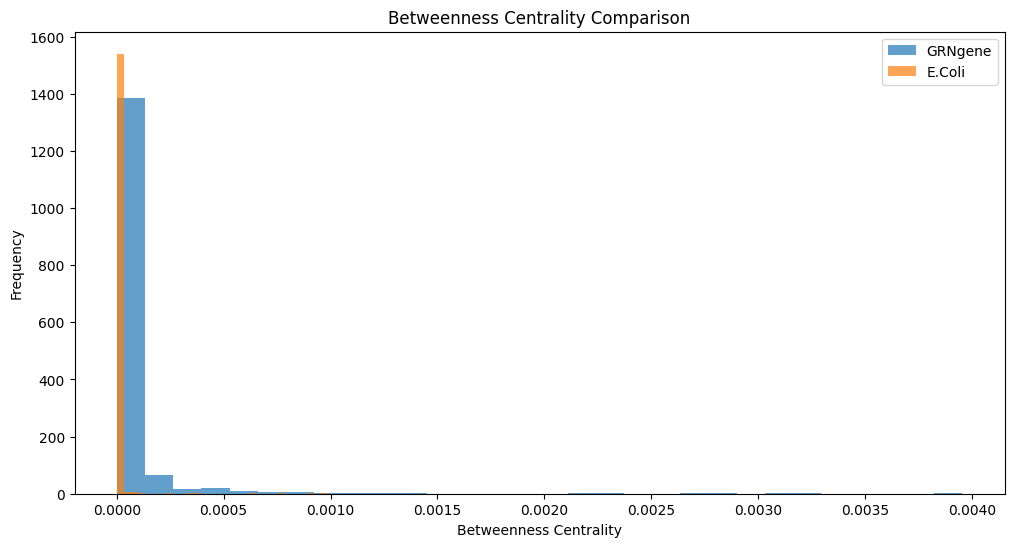

In [7]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

# Load or generate your GRN and the known GRN (e.g., E.Coli TF network)
filepath = 'data/gnw/Ecoli-full.tsv'
adj_mx = adj_mx_gnw_goldstandard(filepath)
generated_grn = G_lfr_directed
known_grn = nx.from_numpy_array(adj_mx, create_using=nx.DiGraph)

# Degree distribution comparison
generated_degrees = [d for n, d in generated_grn.degree()]
known_degrees = [d for n, d in known_grn.degree()]

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.hist(generated_degrees, bins=30, alpha=0.7, label='GRNgene')
plt.hist(known_degrees, bins=30, alpha=0.7, label='E.Coli')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.legend()
plt.title('Degree Distribution Comparison')

# KS test for degree distribution
ks_stat, ks_p_value = ks_2samp(generated_degrees, known_degrees)
print(f"KS Statistic: {ks_stat}, p-value: {ks_p_value}")

# Clustering coefficient comparison
generated_clustering = nx.average_clustering(generated_grn)
known_clustering = nx.average_clustering(known_grn)
print(f"Generated GRN Clustering Coefficient: {generated_clustering}")
print(f"Known GRN Clustering Coefficient: {known_clustering}")

# Path length distribution comparison
generated_path_lengths = dict(nx.shortest_path_length(generated_grn))
known_path_lengths = dict(nx.shortest_path_length(known_grn))

generated_lengths = [length for lengths in generated_path_lengths.values() for length in lengths.values()]
known_lengths = [length for lengths in known_path_lengths.values() for length in lengths.values()]

plt.subplot(122)
plt.hist(generated_lengths, bins=30, alpha=0.7, label='GRNgene')
plt.hist(known_lengths, bins=30, alpha=0.7, label='E.Coli')
plt.xlabel('Path Length')
plt.ylabel('Frequency')
plt.legend()
plt.title('Path Length Distribution Comparison')

plt.show()

# Assortativity comparison
generated_assortativity = nx.degree_assortativity_coefficient(generated_grn)
known_assortativity = nx.degree_assortativity_coefficient(known_grn)
print(f"Generated GRN Assortativity: {generated_assortativity}")
print(f"Known GRN Assortativity: {known_assortativity}")

# Betweenness centrality comparison
generated_betweenness = nx.betweenness_centrality(generated_grn)
known_betweenness = nx.betweenness_centrality(known_grn)

generated_betweenness_values = list(generated_betweenness.values())
known_betweenness_values = list(known_betweenness.values())

plt.figure(figsize=(12, 6))
plt.hist(generated_betweenness_values, bins=30, alpha=0.7, label='GRNgene')
plt.hist(known_betweenness_values, bins=30, alpha=0.7, label='E.Coli')
plt.xlabel('Betweenness Centrality')
plt.ylabel('Frequency')
plt.legend()
plt.title('Betweenness Centrality Comparison')
plt.show()

## Motif distribution (log)

In [4]:
# Extract motifs for E. coli graph

# Load or generate your GRN and the known GRN (e.g., E.Coli TF network)
filepath = 'data/gnw/Ecoli-full.tsv'
adj_mx = adj_mx_gnw_goldstandard(filepath)
generated_grn = G_lfr_directed
known_grn = nx.from_numpy_array(adj_mx, create_using=nx.DiGraph)

ecoli_motifs = subgraph3N(known_grn)
ecoli_motifs_count = get_all_motifs_count(ecoli_motifs)

lfr_motifs = subgraph3N(G_lfr_directed)
motifs_count=get_all_motifs_count(lfr_motifs)

# Ensure both have the same motif keys
all_motifs = set(motifs_count.keys()).union(ecoli_motifs_count.keys())

motifs = sorted(all_motifs)
counts_lfr = [motifs_count.get(m, 0) for m in motifs]
counts_ecoli = [ecoli_motifs_count.get(m, 0) for m in motifs]

# Convert counts to log-scale (add +1 to avoid log(0))
import numpy as np
log_counts_lfr = [np.log10(c + 1) for c in counts_lfr]
log_counts_ecoli = [np.log10(c + 1) for c in counts_ecoli]

# Plot
import matplotlib.pyplot as plt

x = np.arange(len(motifs))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, log_counts_ecoli, width, label='E. coli')
rects2 = ax.bar(x + width/2, log_counts_lfr, width, label='GRNgene')

ax.set_ylabel('Log10(Motif Count)')
ax.set_title('Motif Distribution (Log Scale): E. coli vs GRNgene')
ax.set_xticks(x)
ax.set_xticklabels(motifs, rotation=45)
ax.legend()

plt.tight_layout()
plt.show()

NameError: name 'G_lfr_directed' is not defined

## Motif distribution (normalized)

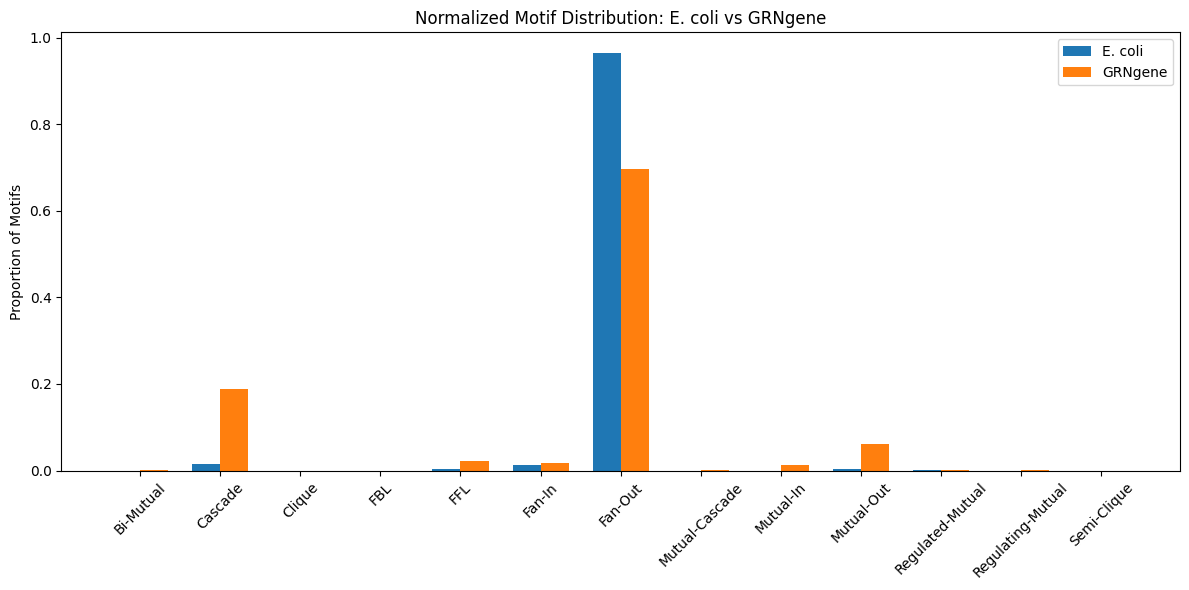

In [9]:
# Normalize counts to get proportions
total_lfr = sum(motifs_count.get(m, 0) for m in motifs)
total_ecoli = sum(ecoli_motifs_count.get(m, 0) for m in motifs)

normalized_lfr = np.array([motifs_count.get(m, 0) / total_lfr for m in motifs])
normalized_ecoli = np.array([ecoli_motifs_count.get(m, 0) / total_ecoli for m in motifs])
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(motifs))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, normalized_ecoli, width, label='E. coli')
rects2 = ax.bar(x + width/2, normalized_lfr, width, label='GRNgene')

ax.set_ylabel('Proportion of Motifs')
ax.set_title('Normalized Motif Distribution: E. coli vs GRNgene')
ax.set_xticks(x)
ax.set_xticklabels(motifs, rotation=45)
ax.legend()

plt.tight_layout()
plt.show()

In [10]:
from scipy.stats import spearmanr

corr, p_corr = spearmanr(counts_lfr, counts_ecoli)
print(f"Spearman correlation: {corr:.3f} (p={p_corr:.5f})")

Spearman correlation: 0.927 (p=0.00001)


In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# import networkx as nx
# from scipy.optimize import curve_fit

# def compare_grn_degree_distributions(adj_mx1, adj_mx2, label1="Network 1", label2="Network 2", plot_fit=True):
#     """
#     Compare the log-log degree distributions of two GRNs side by side.
    
#     Parameters:
#     - adj_mx1: adjacency matrix for first network
#     - adj_mx2: adjacency matrix for second network
#     - label1: label for first network
#     - label2: label for second network
#     - plot_fit: whether to fit and plot power law on each distribution
#     """
#     # Load graphs
#     G1 = nx.from_numpy_array(adj_mx1.toarray(), create_using=nx.DiGraph())
#     G2 = nx.from_numpy_array(adj_mx2.toarray(), create_using=nx.DiGraph())

#     # Degree sequences
#     degree_seq1 = sorted([d for n, d in G1.degree()], reverse=True)
#     degree_seq2 = sorted([d for n, d in G2.degree()], reverse=True)

#     degrees1, counts1 = np.unique(degree_seq1, return_counts=True)
#     degrees2, counts2 = np.unique(degree_seq2, return_counts=True)

#     prob1 = counts1 / G1.number_of_nodes()
#     prob2 = counts2 / G2.number_of_nodes()

#     print(f"{label1} - Number of nodes: {G1.number_of_nodes()}, Number of edges: {G1.number_of_edges()}")
#     print(f"{label1} - Is strongly connected: {nx.is_strongly_connected(G1)}")
#     print(f"{label1} - Is weakly connected: {nx.is_weakly_connected(G1)}")
#     print(f"{label1} - Largest weakly connected component size: {len(max(nx.weakly_connected_components(G1), key=len))}")

#     print(f"{label1} - Number of nodes: {G2.number_of_nodes()}, Number of edges: {G2.number_of_edges()}")
#     print(f"{label1} - Is strongly connected: {nx.is_strongly_connected(G2)}")
#     print(f"{label1} - Is weakly connected: {nx.is_weakly_connected(G2)}")
#     print(f"{label1} - Largest weakly connected component size: {len(max(nx.weakly_connected_components(G2), key=len))}")

#     # Set up figure
#     fig = plt.figure(figsize=(14, 6))
#     axgrid = fig.add_gridspec(2, 4)

#     # Plot network 1
#     ax0 = fig.add_subplot(axgrid[:, 0])
#     #Gcc1 = G1.subgraph(sorted(nx.weakly_connected_components(G1), key=len, reverse=True)[0])
#     pos1 = nx.kamada_kawai_layout(G1)
#     nx.draw_networkx_nodes(G1, pos1, ax=ax0, node_size=10)
#     nx.draw_networkx_edges(G1, pos1, ax=ax0, alpha=0.3)
#     ax0.set_title(label1)
#     ax0.axis('off')

#     # Plot network 2
#     ax1 = fig.add_subplot(axgrid[:, 1])
#     Gcc2 = G2.subgraph(sorted(nx.weakly_connected_components(G2), key=len, reverse=True)[0])
#     pos2 = nx.kamada_kawai_layout(Gcc2)
#     nx.draw_networkx_nodes(Gcc2, pos2, ax=ax1, node_size=10)
#     nx.draw_networkx_edges(Gcc2, pos2, ax=ax1, alpha=0.3)
#     ax1.set_title(label2)
#     ax1.axis('off')

#     # Log-log degree distribution
#     ax2 = fig.add_subplot(axgrid[:, 2:])
#     ax2.scatter(np.log(degrees1 + 1e-6), np.log(prob1 + 1e-6), label=f"{label1}", color='blue', alpha=0.7)
#     ax2.scatter(np.log(degrees2 + 1e-6), np.log(prob2 + 1e-6), label=f"{label2}", color='red', alpha=0.7)
#     ax2.set_xlabel("Log Degree k")
#     ax2.set_ylabel("Log Frequency P(k)")
#     ax2.set_title("Log-Log Degree Distribution Comparison")

#     # Power law fit function
#     def power_law(x, a, b):
#         return a * np.power(x, b)

#     if plot_fit:
#         # Fit network 1
#         try:
#             params1, _ = curve_fit(power_law, degrees1[degrees1 > 0], prob1[degrees1 > 0])
#             ax2.plot(np.log(degrees1[degrees1 > 0]), np.log(power_law(degrees1[degrees1 > 0], *params1)), 
#                      'b--', label=f'{label1} fit (b={params1[1]:.2f})')
#         except Exception as e:
#             print(f"Fit failed for {label1}: {e}")

#         # Fit network 2
#         try:
#             params2, _ = curve_fit(power_law, degrees2[degrees2 > 0], prob2[degrees2 > 0])
#             ax2.plot(np.log(degrees2[degrees2 > 0]), np.log(power_law(degrees2[degrees2 > 0], *params2)), 
#                      'r--', label=f'{label2} fit (b={params2[1]:.2f})')
#         except Exception as e:
#             print(f"Fit failed for {label2}: {e}")

#     ax2.legend()
#     plt.tight_layout()
#     plt.show()


In [15]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from scipy.optimize import curve_fit

def compare_grn_degree_distributions(adj_mx1, adj_mx2, label1="Network 1", label2="Network 2", plot_fit=True):
    """
    Compare the log-log degree distributions of two GRNs in a stacked layout:
    - Left: Network 1 (top) + Network 2 (bottom)
    - Right: Log-log degree distribution comparison
    """
    # Load graphs
    G1 = nx.from_numpy_array(adj_mx1.toarray(), create_using=nx.DiGraph())
    G2 = nx.from_numpy_array(adj_mx2.toarray(), create_using=nx.DiGraph())

    # Degree sequences
    degree_seq1 = sorted([d for n, d in G1.degree()], reverse=True)
    degree_seq2 = sorted([d for n, d in G2.degree()], reverse=True)

    degrees1, counts1 = np.unique(degree_seq1, return_counts=True)
    degrees2, counts2 = np.unique(degree_seq2, return_counts=True)

    prob1 = counts1 / G1.number_of_nodes()
    prob2 = counts2 / G2.number_of_nodes()

    # Set up figure: 2 rows, 2 columns (stacked left side)
    fig = plt.figure(figsize=(14, 8))
    axgrid = fig.add_gridspec(2, 3, width_ratios=[1, 0.05, 2])  # narrow left, wide right

    # Plot network 1 (top left)
    ax0 = fig.add_subplot(axgrid[0, 0])
    Gcc1 = G1.subgraph(sorted(nx.weakly_connected_components(G1), key=len, reverse=True)[0])
    pos1 = nx.kamada_kawai_layout(Gcc1)
    nx.draw_networkx_nodes(Gcc1, pos1, ax=ax0, node_size=10)
    nx.draw_networkx_edges(Gcc1, pos1, ax=ax0, alpha=0.3)
    ax0.set_title(label1)
    ax0.axis('off')

    # Plot network 2 (bottom left)
    ax1 = fig.add_subplot(axgrid[1, 0])
    Gcc2 = G2.subgraph(sorted(nx.weakly_connected_components(G2), key=len, reverse=True)[0])
    pos2 = nx.kamada_kawai_layout(Gcc2)
    nx.draw_networkx_nodes(Gcc2, pos2, ax=ax1, node_size=10)
    nx.draw_networkx_edges(Gcc2, pos2, ax=ax1, alpha=0.3)
    ax1.set_title(label2)
    ax1.axis('off')

    # Log-log degree distribution (right side, spans both rows)
    ax2 = fig.add_subplot(axgrid[:, 2])
    ax2.scatter(np.log(degrees1 + 1e-6), np.log(prob1 + 1e-6), label=f"{label1}", color='blue', alpha=0.7)
    ax2.scatter(np.log(degrees2 + 1e-6), np.log(prob2 + 1e-6), label=f"{label2}", color='red', alpha=0.7)
    ax2.set_xlabel("Log Degree k")
    ax2.set_ylabel("Log Frequency P(k)")
    ax2.set_title("Log-Log Degree Distribution Comparison")

    # Power law fit function
    def power_law(x, a, b):
        return a * np.power(x, b)

    if plot_fit:
        # Fit network 1
        try:
            params1, _ = curve_fit(power_law, degrees1[degrees1 > 0], prob1[degrees1 > 0])
            ax2.plot(np.log(degrees1[degrees1 > 0]), np.log(power_law(degrees1[degrees1 > 0], *params1)),
                     'b--', label=f'{label1} fit (b={params1[1]:.2f})')
        except Exception as e:
            print(f"Fit failed for {label1}: {e}")

        # Fit network 2
        try:
            params2, _ = curve_fit(power_law, degrees2[degrees2 > 0], prob2[degrees2 > 0])
            ax2.plot(np.log(degrees2[degrees2 > 0]), np.log(power_law(degrees2[degrees2 > 0], *params2)),
                     'r--', label=f'{label2} fit (b={params2[1]:.2f})')
        except Exception as e:
            print(f"Fit failed for {label2}: {e}")

    ax2.legend()
    plt.tight_layout()
    plt.show()


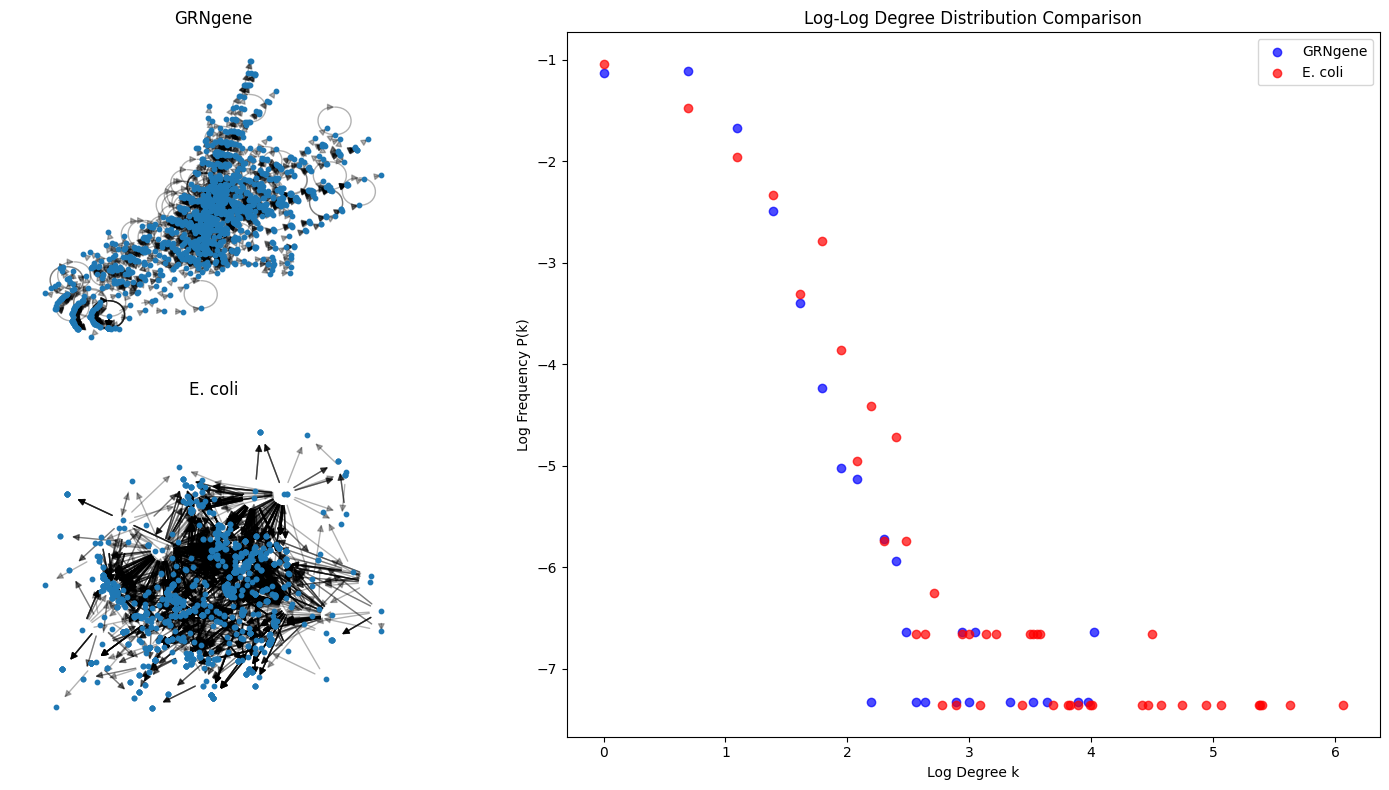

In [16]:
# Get adjacency matrices
lfr_adj_mx = nx.adjacency_matrix(G_lfr_directed)
gnw_adj_mx = adj_mx_gnw_goldstandard(filepath)

# Call the comparison plot
compare_grn_degree_distributions(
    lfr_adj_mx,
    gnw_adj_mx,
    label1="GRNgene",
    label2="E. coli",
    plot_fit=False
)


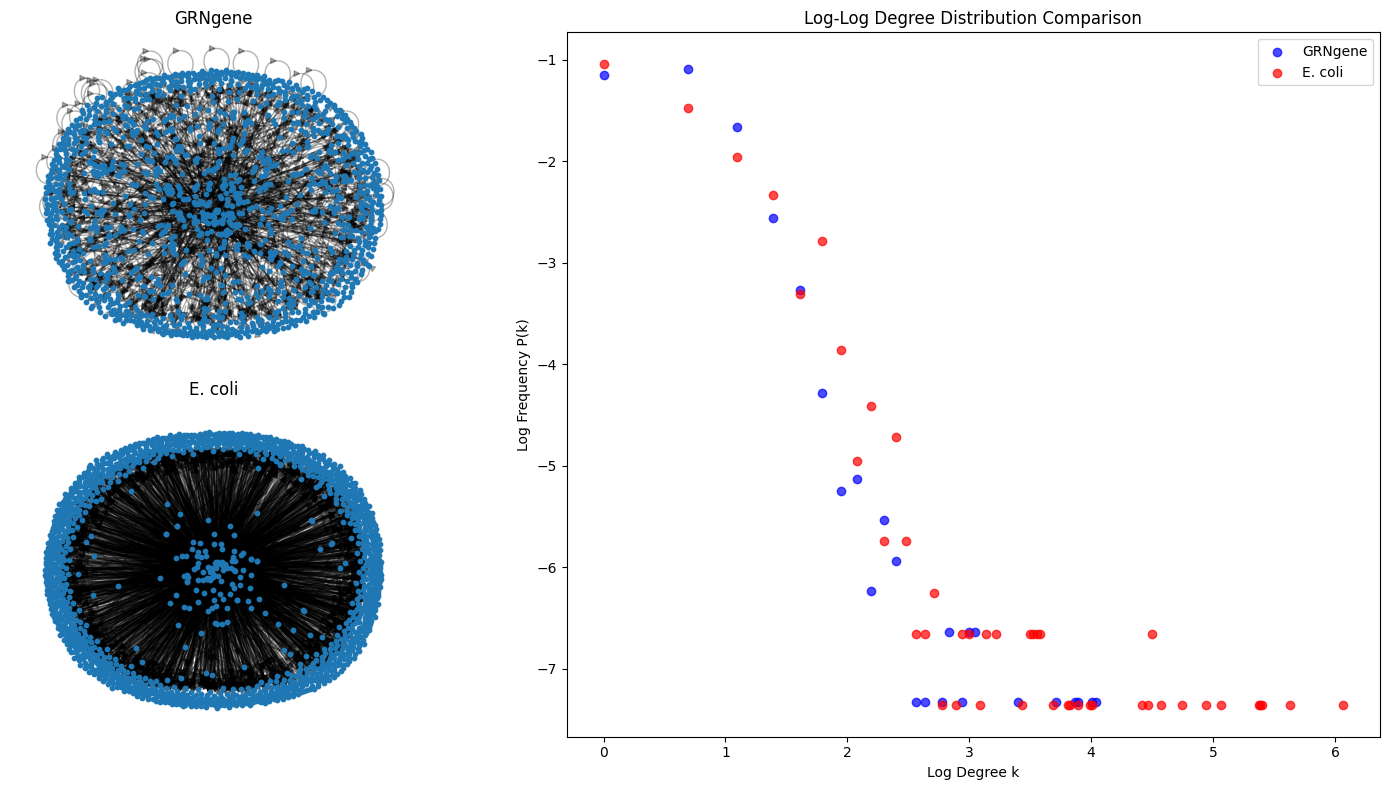

In [12]:
# Get adjacency matrices
lfr_adj_mx = nx.adjacency_matrix(G_lfr_directed)
gnw_adj_mx = adj_mx_gnw_goldstandard(filepath)

# Call the comparison plot
compare_grn_degree_distributions(
    lfr_adj_mx,
    gnw_adj_mx,
    label1="GRNgene",
    label2="E. coli",
    plot_fit=False
)
